In [3]:
#@title Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
import joblib
import warnings
warnings.filterwarnings('ignore')

In [6]:
#@title Data
url = "https://raw.githubusercontent.com/Mechademy-Git/DS-Intern-Assignment/refs/heads/main/data/data.csv"
df = pd.read_csv(url)
df

,timestamp,equipment_energy_consumption,lighting_energy,zone1_temperature,zone1_humidity,zone2_temperature,zone2_humidity,zone3_temperature,zone3_humidity,zone4_temperature,...,zone9_temperature,zone9_humidity,outdoor_temperature,atmospheric_pressure,outdoor_humidity,wind_speed,visibility_index,dew_point,random_variable1,random_variable2
0,2016-01-11 17:00:00,60.0,-77.78778596503064,33.74660933896648,47.59666666666671,19.2,44.790000,19.79,NaN,19.000000,...,17.033333,45.53,6.600000,733.500000,92.000000,7.000000,63.000000,5.300000,13.275433,13.275433
1,2016-01-11 17:10:00,60.0,30.0,19.89,46.69333333333329,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.600000,92.000000,6.666667,59.166667,5.200000,18.606195,18.606195
2,2016-01-11 17:20:00,50.0,30.0,19.89,46.3,19.2,44.626667,19.79,44.933333,35.921144,...,17.000000,45.50,6.366667,733.700000,92.000000,6.333333,55.333333,5.100000,28.642668,28.642668
3,2016-01-11 17:30:00,50.0,40.0,33.74660933896648,46.0666666666667,19.2,44.590000,19.79,45.000000,NaN,...,17.000000,45.40,6.250000,733.800000,92.000000,6.000000,51.500000,37.673716,45.410389,45.410389
4,2016-01-11 17:40:00,60.0,40.0,19.89,46.33333333333329,19.2,44.530000,19.79,45.000000,18.890000,...,4.476511,45.40,6.133333,733.900000,92.000000,5.666667,47.666667,4.900000,10.084097,10.084097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16852,2016-10-03 20:10:00,1139.9856929495108,20.0,22.1,38.723333333333294,19.79,39.566667,21.29,38.845000,21.390000,...,18.100000,40.09,5.816667,761.466667,68.333333,2.000000,64.666667,0.366667,10.707282,10.707282
16853,2016-10-04 06:10:00,50.0,86.00296632575207,21.29,39.6266666666667,18.1,44.290000,22.39,38.760000,NaN,...,20.200000,44.50,3.683333,752.250000,96.666667,1.000000,18.000000,3.150000,49.199695,49.199695
16854,2016-11-03 00:50:00,50.0,0.0,21.39,37.59,18.463333333333296,39.966667,21.10,37.790000,20.600000,...,18.100000,40.20,1.750000,763.000000,84.166667,1.000000,60.833333,-0.633333,6.905370,6.905370
16855,2016-11-04 13:20:00,80.0,0.0,22.5,39.36,23.6,35.730000,23.10,38.000000,22.290000,...,21.100000,39.53,16.800000,750.166667,50.333333,6.000000,40.000000,6.266667,25.020775,25.020775


In [3]:
#@title Data Preprocessing
def preprocess_data(df):
  for col in df.columns:
    if col != 'timestamp':
      df[col] = pd.to_numeric(df[col], errors='coerce')
  df = df.dropna(subset=['equipment_energy_consumption'])
  features = df.columns.drop(['timestamp', 'equipment_energy_consumption'])
  imputer = SimpleImputer(strategy='median')
  df[features] = imputer.fit_transform(df[features])
  df['timestamp'] = pd.to_datetime(df['timestamp'])
  df['hour'] = df['timestamp'].dt.hour
  df['dayofweek'] = df['timestamp'].dt.dayofweek
  df['is_weekend'] = df['dayofweek'].isin([5,6]).astype(int)
  df = df.drop(columns=['timestamp'])
  corr = df.corr()['equipment_energy_consumption'].sort_values(ascending=False)
  if 'random_variable1' in corr and abs(corr['random_variable1']) < 0.01:
    df = df.drop(columns=['random_variable1'])
  if 'random_variable2' in corr and abs(corr['random_variable2']) < 0.01:
    df = df.drop(columns=['random_variable2'])
  return df

df = preprocess_data(df)

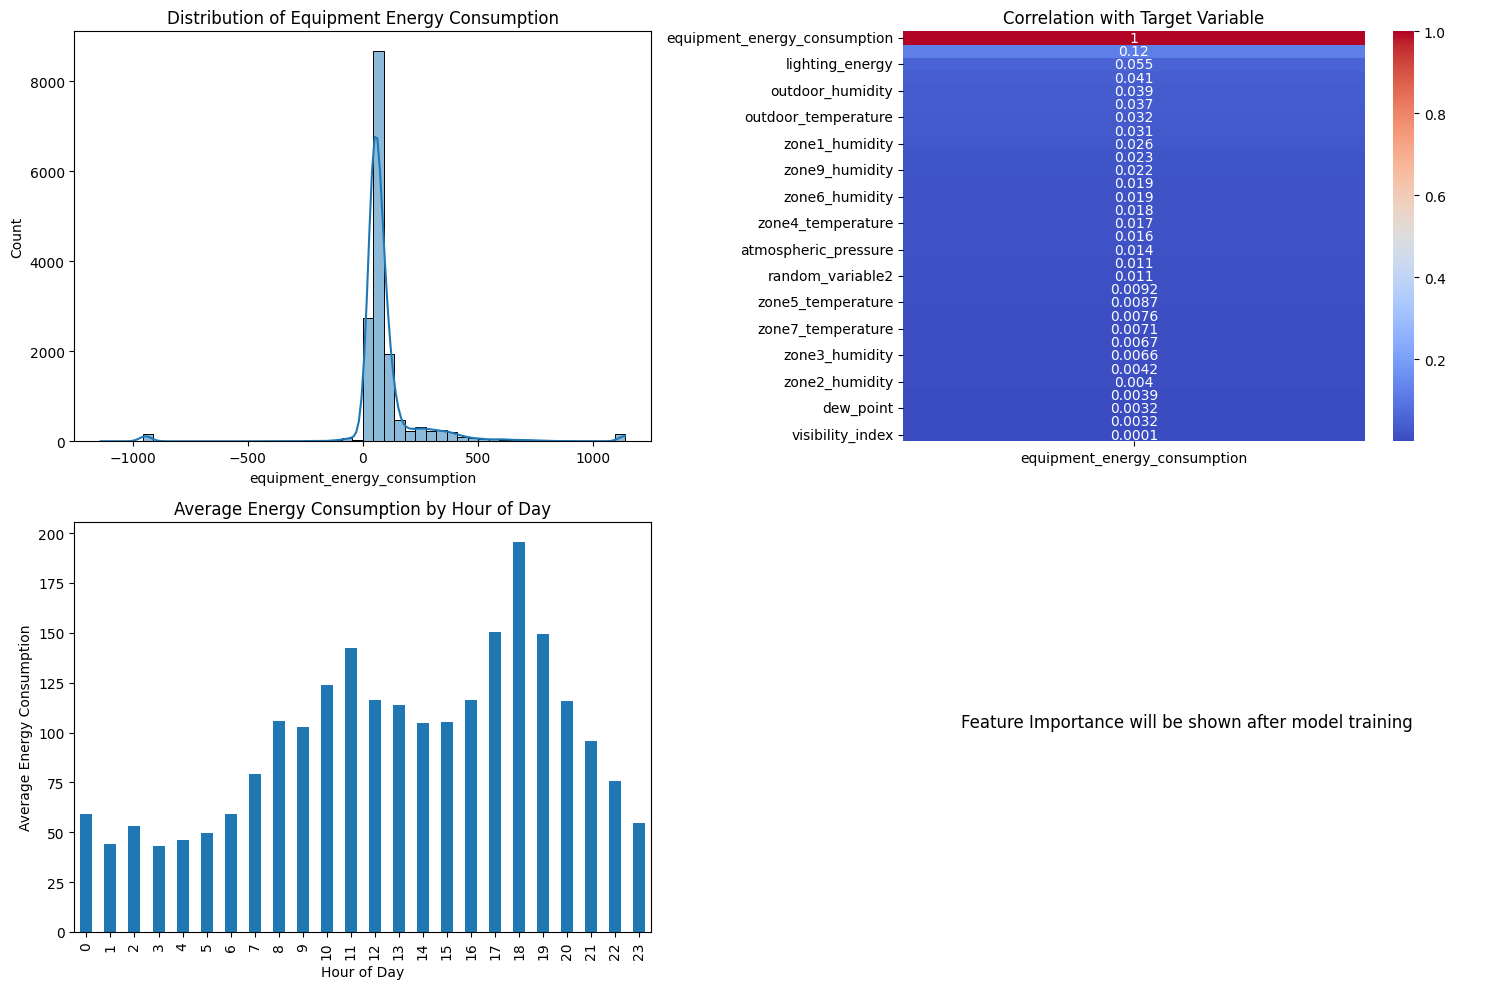

In [4]:
#@title EDA
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.histplot(df['equipment_energy_consumption'], bins=50, kde=True)
plt.title('Distribution of Equipment Energy Consumption')


plt.subplot(2, 2, 2)
corr_matrix = df.corr().abs()
sns.heatmap(corr_matrix[['equipment_energy_consumption']].sort_values(by='equipment_energy_consumption', ascending=False),
            annot=True, cmap='coolwarm')
plt.title('Correlation with Target Variable')




plt.subplot(2, 2, 3)
hourly_avg = df.groupby('hour')['equipment_energy_consumption'].mean()
hourly_avg.plot(kind='bar')
plt.title('Average Energy Consumption by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Energy Consumption')


plt.subplot(2, 2, 4)
plt.text(0.1, 0.5, 'Feature Importance will be shown after model training', fontsize=12)
plt.axis('off')
plt.tight_layout()
plt.show()


In [5]:
X = df.drop(columns=['equipment_energy_consumption'])
y = df['equipment_energy_consumption']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
#@title Model 1: Random Forest
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(random_state=42))
])
rf_params = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [2, 5]
}
rf_grid = GridSearchCV(rf_pipeline, rf_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
rf_grid.fit(X_train, y_train)
rf_best = rf_grid.best_estimator_


In [7]:
#@title Model 2: Gradient Boosting
gb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', GradientBoostingRegressor(random_state=42))
])
gb_params = {
    'regressor__n_estimators': [100, 200],
    'regressor__learning_rate': [0.01, 0.1],
    'regressor__max_depth': [3, 5]
}
gb_grid = GridSearchCV(gb_pipeline, gb_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
gb_grid.fit(X_train, y_train)
gb_best = gb_grid.best_estimator_


In [8]:
#@title Model 3: XGBoost
from xgboost import XGBRegressor
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', XGBRegressor(random_state=42, verbosity=0))
])
xgb_params = {
    'regressor__n_estimators': [100, 200],
    'regressor__learning_rate': [0.01, 0.1],
    'regressor__max_depth': [3, 5]
}
xgb_grid = GridSearchCV(xgb_pipeline, xgb_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
xgb_grid.fit(X_train, y_train)
xgb_best = xgb_grid.best_estimator_

In [9]:
#@title Evaluate model based on RMSE, MAE and R²
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"\n{model_name} Performance:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R²: {r2:.3f}")
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    print(f"Cross-validated R²: {np.mean(cv_scores):.3f} (±{np.std(cv_scores):.3f})")
    return rmse, mae, r2


In [10]:
#@title Model Comparison
print("=== Model Comparison ===")
rf_metrics = evaluate_model(rf_best, X_test, y_test, "Random Forest")
gb_metrics = evaluate_model(gb_best, X_test, y_test, "Gradient Boosting")
xgb_metrics = evaluate_model(xgb_best, X_test, y_test, "XGBoost")


=== Model Comparison ===

Random Forest Performance:
RMSE: 158.13
MAE: 67.61
R²: 0.069
Cross-validated R²: 0.060 (±0.022)

Gradient Boosting Performance:
RMSE: 157.84
MAE: 66.20
R²: 0.072
Cross-validated R²: 0.053 (±0.009)

XGBoost Performance:
RMSE: 157.49
MAE: 65.86
R²: 0.076
Cross-validated R²: 0.057 (±0.010)


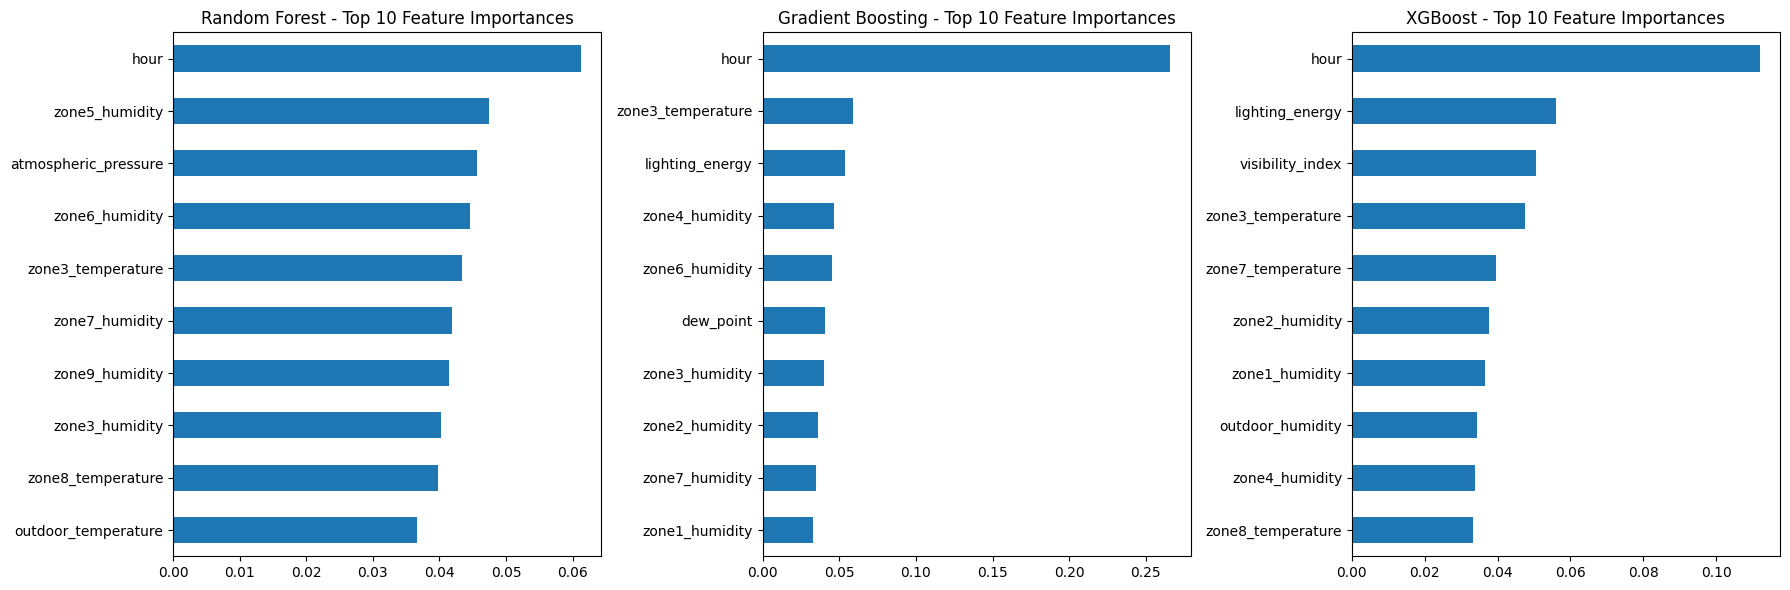

In [11]:
#@title Top 10 Feature Importances

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
pd.Series(rf_best.named_steps['regressor'].feature_importances_, index=X.columns).nlargest(10).sort_values().plot(kind='barh')
plt.title('Random Forest - Top 10 Feature Importances')

plt.subplot(1, 3, 2)
pd.Series(gb_best.named_steps['regressor'].feature_importances_, index=X.columns).nlargest(10).sort_values().plot(kind='barh')
plt.title('Gradient Boosting - Top 10 Feature Importances')


plt.subplot(1, 3, 3)
pd.Series(xgb_best.named_steps['regressor'].feature_importances_, index=X.columns).nlargest(10).sort_values().plot(kind='barh')
plt.title('XGBoost - Top 10 Feature Importances')
plt.tight_layout()
plt.show()

In [12]:
metrics_df = pd.DataFrame({
    'Model': ['Random Forest', 'Gradient Boosting', 'XGBoost'],
    'RMSE': [rf_metrics[0], gb_metrics[0], xgb_metrics[0]],
    'MAE': [rf_metrics[1], gb_metrics[1], xgb_metrics[1]],
    'R²': [rf_metrics[2], gb_metrics[2], xgb_metrics[2]]
})
print("\n=== Final Model Comparison ===")
print(metrics_df)


=== Final Model Comparison ===
               Model        RMSE        MAE        R²
0      Random Forest  158.125090  67.613033  0.068616
1  Gradient Boosting  157.836509  66.199244  0.072013
2            XGBoost  157.494704  65.863608  0.076027


In [13]:
#@title Key Insights and Recommendations
print("\n=== Key Insights and Recommendations ===")
top_features = pd.Series(xgb_best.named_steps['regressor'].feature_importances_, index=X.columns).nlargest(5).index.tolist()
print(f"1. Top influencing features (XGBoost): {', '.join(top_features)}")
print("2. Energy varies by hour; optimize during off-peak times")
print("3. Focus on environmental factors from top features")
print("4. Predictive maintenance can reduce unexpected spikes")



=== Key Insights and Recommendations ===
1. Top influencing features (XGBoost): hour, lighting_energy, visibility_index, zone3_temperature, zone7_temperature
2. Energy varies by hour; optimize during off-peak times
3. Focus on environmental factors from top features
4. Predictive maintenance can reduce unexpected spikes


In [14]:
joblib.dump(xgb_best, 'energy_consumption_xgb_model.pkl')
print("\nBest model (XGBoost) saved as 'energy_consumption_xgb_model.pkl'")



Best model (XGBoost) saved as 'energy_consumption_xgb_model.pkl'
